In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (207 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def make_dir(base_path, level):
    level_dir = f'{base_path}{level}level'
    if not os.path.exists(level_dir):
        os.mkdir(level_dir)
    train_image_dir = os.path.join(level_dir,'train_image/')
    train_mask_dir = os.path.join(level_dir,'train_mask/')

    val_image_dir = os.path.join(level_dir,'val_image/')
    val_mask_dir = os.path.join(level_dir,'val_mask/')

    test_image_dir = os.path.join(level_dir,'test_image/')
    test_mask_dir = os.path.join(level_dir,'test_mask/')

    if not os.path.exists(train_image_dir):
        os.mkdir(train_image_dir)
    if not os.path.exists(train_mask_dir):
        os.mkdir(train_mask_dir)
    if not os.path.exists(val_image_dir):
        os.mkdir(val_image_dir)
    if not os.path.exists(val_mask_dir):
        os.mkdir(val_mask_dir)    
    if not os.path.exists(test_image_dir):
        os.mkdir(test_image_dir)
    if not os.path.exists(test_mask_dir):
        os.mkdir(test_mask_dir)
    return(train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir)

In [5]:
base_path = '/content/'
train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir = make_dir(base_path, level = 'multi_')

In [6]:
train_image_dir

'/content/multi_level/train_image/'

In [7]:
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/multi_level/train_image.zip' -d /content/multi_level/train_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/multi_level/val_image.zip' -d /content/multi_level/val_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/multi_level/test_image.zip' -d /content/multi_level/test_image/

In [8]:
!cp '/content/drive/MyDrive/Applied Deep Learning/project/multi_level/multi_level_train_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/multi_level/multi_level_val_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/multi_level/multi_level_test_data.txt' /content/

In [9]:
train_df = pd.read_csv('/content/multi_level_train_data.txt', header = None)
val_df = pd.read_csv('/content/multi_level_val_data.txt', header = None)
test_df = pd.read_csv('/content/multi_level_test_data.txt', header = None)
cols = ['Low Res Image Paths', 'High Res Image Paths', 'Low Res Xoffset', 'Low Res Yoffset', 'High Res Xoffset', 
                                                     'High Res Yoffset', 'Labels', 'slide code', 'Low Res Level', 'High Res Level']
train_df.columns, val_df.columns, test_df.columns = cols, cols, cols

train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

train_df['Labels'] = train_df['Labels'].astype(str)
val_df['Labels'] = val_df['Labels'].astype(str)
test_df['Labels'] = test_df['Labels'].astype(str)

In [10]:
train_df.head()

,Low Res Image Paths,High Res Image Paths,Low Res Xoffset,Low Res Yoffset,High Res Xoffset,High Res Yoffset,Labels,slide code,Low Res Level,High Res Level
0,/content/multi_level/train_image/normal/slide0...,/content/multi_level/train_image/normal/slide0...,5248,1024,10644,2196,0,96,4,3
1,/content/multi_level/train_image/normal/slide1...,/content/multi_level/train_image/normal/slide1...,1536,1536,3220,3220,0,101,4,3
2,/content/multi_level/train_image/normal/slide0...,/content/multi_level/train_image/normal/slide0...,3072,1152,6292,2452,0,91,4,3
3,/content/multi_level/train_image/normal/slide0...,/content/multi_level/train_image/normal/slide0...,2816,7040,5780,14228,0,57,4,3
4,/content/multi_level/train_image/normal/slide0...,/content/multi_level/train_image/normal/slide0...,3328,4096,6804,8340,0,78,4,3


In [11]:
train_df.shape

(6440, 10)

In [107]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)
def data_generator_aug(train_datagen, df, train_image_dir):
    train_generator1 = train_datagen.flow_from_dataframe(
        dataframe = df,
        directory = train_image_dir,
        x_col = 'Low Res Image Paths',
        y_col = 'Labels',
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle=False,
        seed = 2404,
    )
    train_generator2 = train_datagen.flow_from_dataframe(
        dataframe = df,
        directory = train_image_dir,
        x_col = 'High Res Image Paths',
        y_col = 'Labels',
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle=False,
        seed = 2404,
    )
    while True:
        a, label = train_generator1.next()
        b = train_generator2.next()[0]
        yield([a, b], label)

# Multi-level Model

In [112]:
IMG_SIZE = 299
batch_size = 32
multi_train_generator = data_generator_aug(train_datagen, train_df, train_image_dir)
multi_val_generator = data_generator_aug(test_datagen, val_df, val_image_dir)
multi_test_generator = data_generator_aug(test_datagen, test_df, test_image_dir)

In [113]:
IMG_SIZE = 299
vgg_base_1 = tf.keras.applications.VGG16(
            include_top = False,
            weights = 'imagenet',
            input_shape = (IMG_SIZE, IMG_SIZE, 3),
            pooling = None,
            classes = 2,
            classifier_activation = 'softmax',
        )
vgg_base_2 = tf.keras.applications.VGG16(
            include_top = False,
            weights = 'imagenet',
            input_shape = (IMG_SIZE, IMG_SIZE, 3),
            pooling = None,
            classes = 2,
            classifier_activation = 'softmax',
        )
vgg_base_1.trainable = False
vgg_base_2.trainable = False


high_res_level_input = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
low_res_level_input = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# high resolution level
high_res_vgg = tf.keras.Sequential([
    vgg_base_1,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(128, activation='relu')
])
high_res_vgg_output = high_res_vgg(high_res_level_input)

# low resolution level
low_res_vgg = tf.keras.Sequential([
    vgg_base_2,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(128, activation='relu'),
])
low_res_vgg_output = low_res_vgg(low_res_level_input)

# concatenate two output layers as input
concatenated_input = tf.keras.layers.concatenate([high_res_vgg_output, low_res_vgg_output])
flattened = tf.keras.layers.Flatten()(concatenated_input)

output = tf.keras.layers.Dense(128, activation="relu")(flattened)
output = tf.keras.layers.Dropout(0.4)(output)
output = tf.keras.layers.Dense(2, activation="softmax")(output)

vgg_multi_resolution_model = tf.keras.Model(inputs=[high_res_level_input, low_res_level_input], outputs=output)
vgg_multi_resolution_model.summary()

vgg_multi_resolution_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                                   loss = 'sparse_categorical_crossentropy',
                                   metrics = ['accuracy'])

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_22 (Sequential)      (None, 512)          14714688    input_47[0][0]                   
__________________________________________________________________________________________________
sequential_23 (Sequential)      (None, 512)          14714688    input_48[0][0]                   
___________________________________________________________________________________________

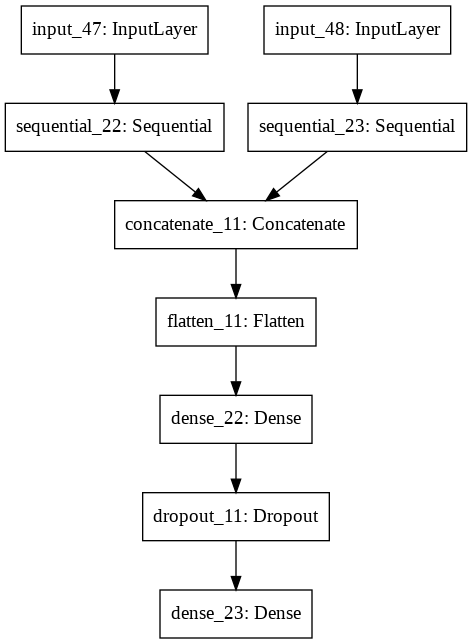

In [114]:
tf.keras.utils.plot_model(vgg_multi_resolution_model)

In [115]:
if not os.path.exists('/content/checkpoint'):
  os.mkdir('/content/checkpoint')
if not os.path.exists('/content/checkpoint/VGG'):
  os.mkdir('/content/checkpoint/VGG')
multi_vgg_checkpoint_path = '/content/checkpoint/VGG/multi_level_weights-improvement-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'
vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(multi_vgg_checkpoint_path, 
                                                                    monitor='val_loss', 
                                                                    save_best_only=True, 
                                                                    mode='auto')

vgg_early_stop_callback = tf.keras.callbacks.EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=10)

In [116]:
for data_batch, labels_batch in multi_train_generator:
    print('Train data: ')
    print('data batch shape:', len(data_batch))
    print('data batch', data_batch[0].shape)
    print('data batch2', data_batch[1].shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 6440 validated image filenames belonging to 2 classes.
Found 6440 validated image filenames belonging to 2 classes.
Train data: 
data batch shape: 2
data batch (32, 299, 299, 3)
data batch2 (32, 299, 299, 3)
labels batch shape: (32,)


In [117]:
for data_batch, labels_batch in multi_val_generator:
    print('Train data: ')
    print('data batch shape:', len(data_batch))
    print('data batch', data_batch[0].shape)
    print('data batch2', data_batch[1].shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 1458 validated image filenames belonging to 2 classes.
Found 1458 validated image filenames belonging to 2 classes.
Train data: 
data batch shape: 2
data batch (32, 299, 299, 3)
data batch2 (32, 299, 299, 3)
labels batch shape: (32,)


In [118]:
steps_per_epoch = train_df.shape[0] // batch_size
validation_steps = val_df.shape[0] // batch_size

In [119]:
epochs = 10
multi_level_vgg_history = vgg_multi_resolution_model.fit(multi_train_generator, 
                                                          epochs = epochs,
                                                          steps_per_epoch = steps_per_epoch,
                                                          validation_steps = validation_steps,
                                                          validation_data = multi_val_generator,
                                                          callbacks=[vgg_checkpoint_callback, 
                                                                    vgg_early_stop_callback])

Epoch 1/10
201/201 [==============================] - 298s 1s/step - loss: 0.2940 - accuracy: 0.9079 - val_loss: 0.0835 - val_accuracy: 0.9846
Epoch 2/10
201/201 [==============================] - 300s 1s/step - loss: 0.2012 - accuracy: 0.9324 - val_loss: 0.0721 - val_accuracy: 0.9811
Epoch 3/10
201/201 [==============================] - 300s 1s/step - loss: 0.1806 - accuracy: 0.9380 - val_loss: 0.0673 - val_accuracy: 0.9804
Epoch 4/10
201/201 [==============================] - 300s 1s/step - loss: 0.1707 - accuracy: 0.9453 - val_loss: 0.0671 - val_accuracy: 0.9797
Epoch 5/10
201/201 [==============================] - 302s 2s/step - loss: 0.1669 - accuracy: 0.9455 - val_loss: 0.0732 - val_accuracy: 0.9748
Epoch 6/10
201/201 [==============================] - 302s 2s/step - loss: 0.1635 - accuracy: 0.9458 - val_loss: 0.0759 - val_accuracy: 0.9748
Epoch 7/10
201/201 [==============================] - 302s 2s/step - loss: 0.1560 - accuracy: 0.9433 - val_loss: 0.0745 - val_accuracy: 0.9755

In [123]:
 vgg_multi_resolution_model.save('/content/vgg_multi_resolution_model1.h5')